<a href="https://colab.research.google.com/github/tans124/stock-prediction/blob/master/Timeseries_Pattern_Recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install minisom
!pip install tslearn

  Created wheel for minisom: filename=MiniSom-2.2.9-py3-none-any.whl size=8592 sha256=2d949b428467d6de0a4b72e28a132d8f4afe637a109de446ded02a3fc3aaef05
  Stored in directory: /root/.cache/pip/wheels/3d/a1/10/f50b6f4865652eac239a2700de411c3078c27e1318320e494c
Successfully built minisom
     |████████████████████████████████| 793 kB 8.0 MB/s 


## **Libraries**

In [3]:
import seaborn as sns
sns.set()
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


## **Dataset Preprocessing**

In [5]:
url = 'https://raw.githubusercontent.com/tans124/stock-prediction/master/data/stock_prices_sample.csv'
data = pd.read_csv(url)

In [6]:
data.head(3)

TICKER          FIGI        DATE  ... ADJ_FACTOR EX_DIVIDEND  SPLIT_RATIO
0    GEF  BBG000BLFQH8  2013-01-04  ...        NaN         0.0          1.0
1    GEF  BBG000BLFQH8  2013-01-03  ...        NaN         0.0          1.0
2    GEF  BBG000BLFQH8  2013-01-02  ...        NaN         0.0          1.0

[3 rows x 18 columns]

In [7]:
data.shape

(999, 18)

In [8]:
data.dtypes

TICKER          object
FIGI            object
DATE            object
TYPE            object
FREQUENCY       object
OPEN           float64
HIGH           float64
LOW            float64
CLOSE          float64
VOLUME         float64
ADJ_OPEN       float64
ADJ_HIGH       float64
ADJ_LOW        float64
ADJ_CLOSE      float64
ADJ_VOLUME     float64
ADJ_FACTOR     float64
EX_DIVIDEND    float64
SPLIT_RATIO    float64
dtype: object

In [9]:
data = data[data.TICKER != 'GEF']
data = data[data.TYPE != 'Intraday']

In [10]:
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']
data.drop(drop_cols, axis=1, inplace=True)

Text(0.5, 0, 'Trading day')

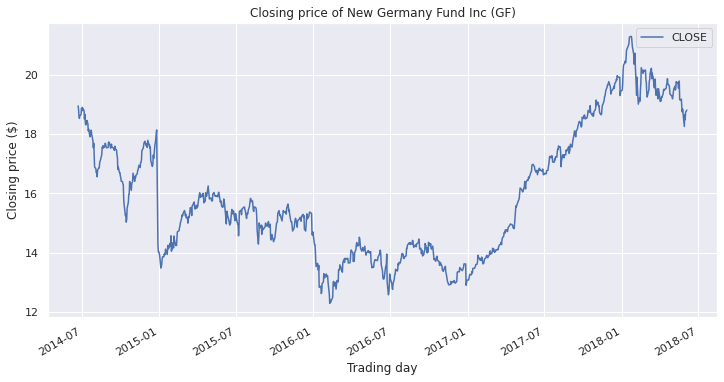

In [11]:
data.DATE = pd.to_datetime(data.DATE) # convert date column to DateTime
ax = data.plot(x='DATE', y='CLOSE', figsize=(12,6))
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')

## **Trend & Seasonality**

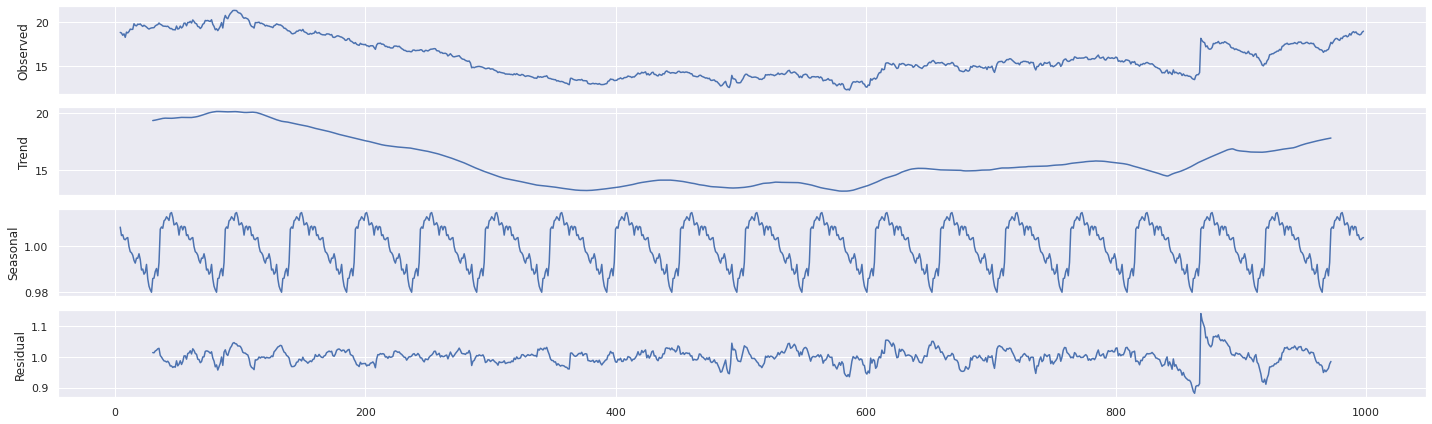

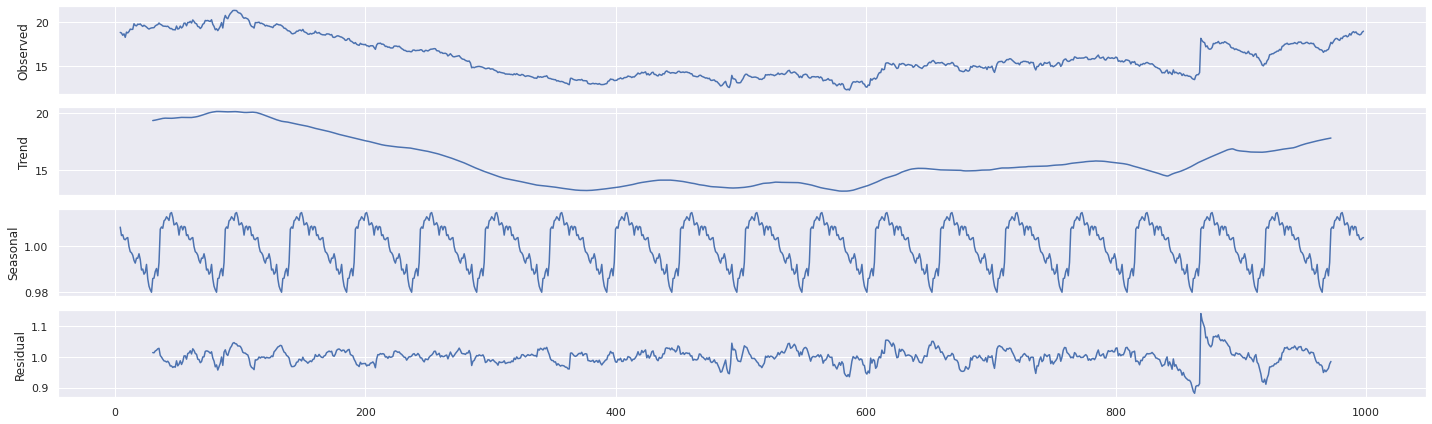

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
data.sort_index(inplace= True)
analysis = data[['CLOSE']].copy()
decompose_result_mult = seasonal_decompose(analysis, model="multiplicative",filt=None, freq= 52)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
plt.rc("figure", figsize=(20,6))
decompose_result_mult.plot()

## **Predicting Values**

In [13]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

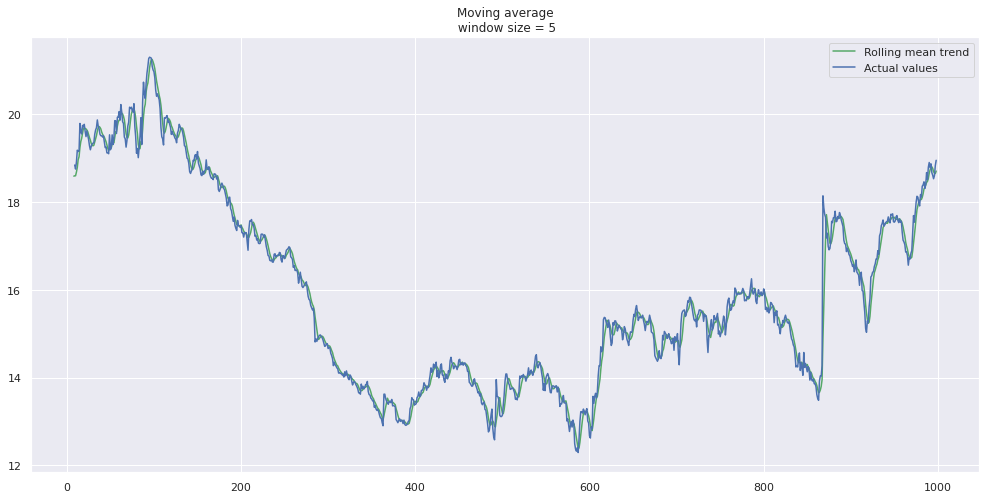

In [14]:
plot_moving_average(data.CLOSE, 5)

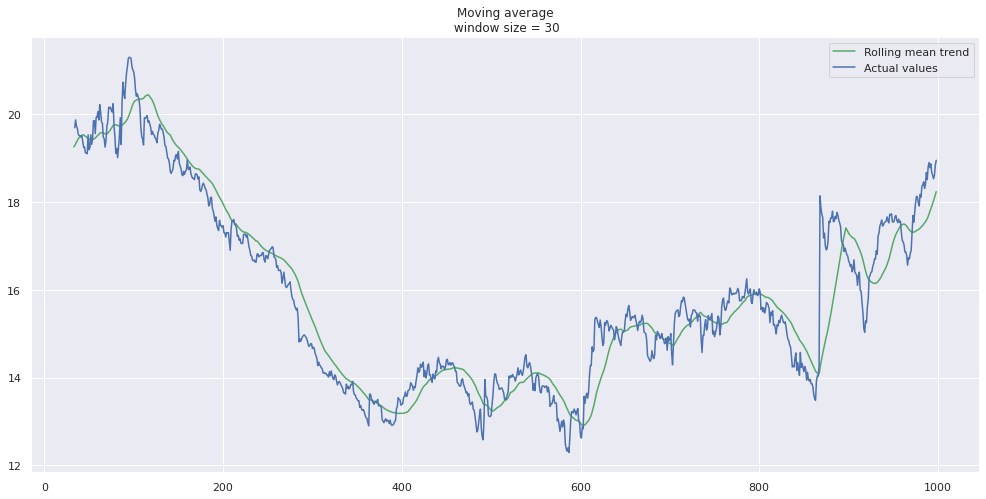

In [15]:
plot_moving_average(data.CLOSE, 30)

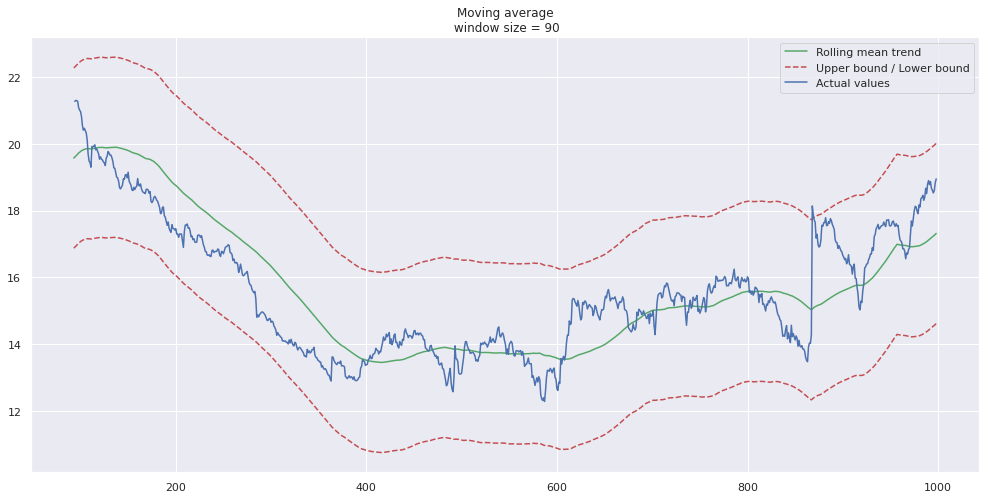

In [16]:
plot_moving_average(data.CLOSE, 90, plot_intervals=True)

In [17]:
def exponential_smoothing(series, alpha):
    result = [series.iloc[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])
    return result

In [18]:
def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

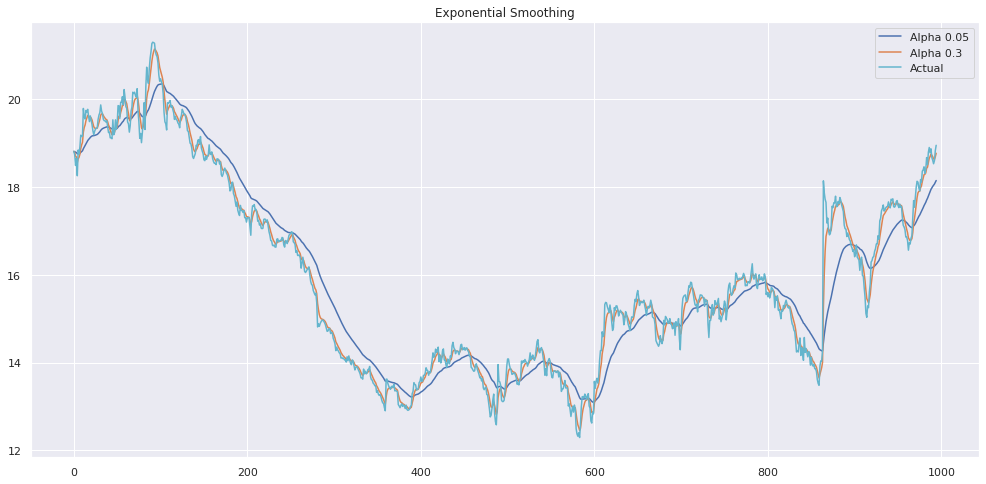

In [19]:
plot_exponential_smoothing(data.CLOSE, [0.05, 0.3])

In [20]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series.iloc[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series.iloc[0], series.iloc[1] - series.iloc[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series.iloc[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [21]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

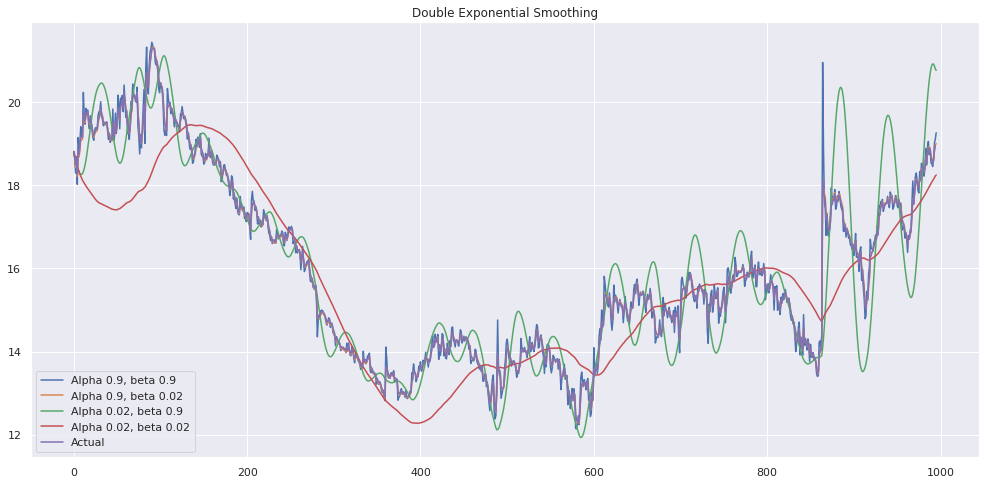

In [22]:
plot_double_exponential_smoothing(data.CLOSE, alphas=[0.9, 0.02], betas=[0.9, 0.02])

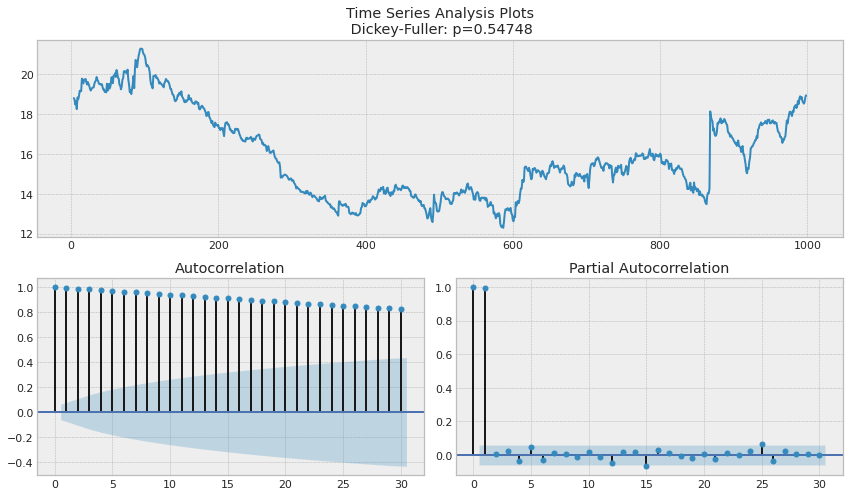

In [23]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.CLOSE, lags=30)

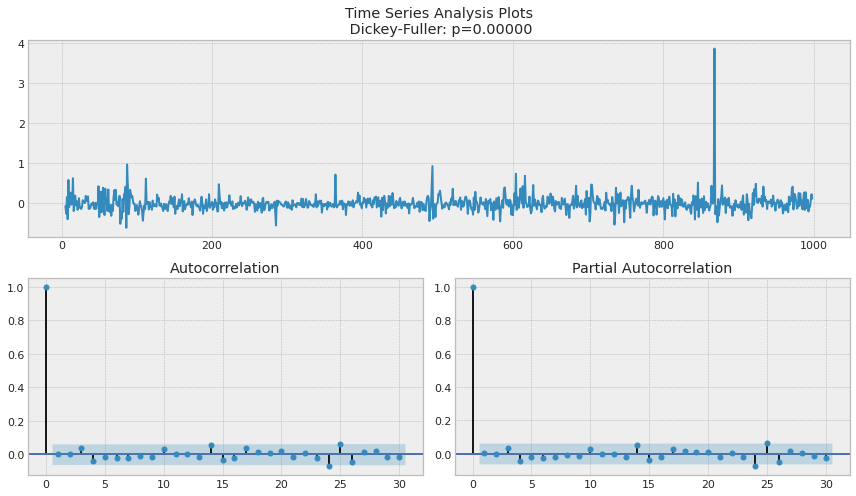

In [24]:
data_diff = data.CLOSE - data.CLOSE.shift(1)
tsplot(data_diff[1:], lags=30)

## **SARIMA**

In [25]:
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [26]:
def optimize_SARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [69]:
p, q, P, Q = result_table.parameters[0]
best_model = sm.tsa.statespace.SARIMAX(data.CLOSE, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             CLOSE   No. Observations:                  995
Model:             SARIMAX(0, 1, 0)x(2, 1, 3, 5)   Log Likelihood                 147.748
Date:                           Thu, 12 Aug 2021   AIC                           -283.496
Time:                                   23:46:53   BIC                           -254.116
Sample:                                        0   HQIC                          -272.324
                                           - 995                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.8520      0.185     -4.601      0.000      -1.215      -0.489
ar.S.L10      -0.7651      0.158     -4.829

In [70]:
def plot_SARIMA(series, model, n_steps):
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
print(best_model.predict(start=data.CLOSE.shape[0], end=data.CLOSE.shape[0] + 5))
print(mean_absolute_percentage_error(data.CLOSE[s+d:], best_model.fittedvalues[s+d:]))

995     18.972651
996     18.973318
997     18.955933
998     18.923402
999     18.949691
1000    18.931503
dtype: float64
0.7843684934221677


In [71]:
comparison = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
                          'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]}, 
                          index = pd.date_range(start='2018-06-05', periods=6,))

In [72]:
comparison.head()

actual  predicted
2018-06-05   18.93      18.96
2018-06-06   19.23      18.97
2018-06-07   19.08      18.96
2018-06-08   19.17      18.92
2018-06-09   19.11      18.94

## **Timeseries Analysis**

In [27]:
from google.colab import files
uploaded = files.upload()

Saving MRTSMPCSM4400CUSN.csv to MRTSMPCSM4400CUSN.csv
Saving MRTSSM44X72USS.csv to MRTSSM44X72USS.csv
Saving MRTSSM442USN.csv to MRTSSM442USN.csv
Saving MRTSSM442USS.csv to MRTSSM442USS.csv
Saving MRTSSM444USS.csv to MRTSSM444USS.csv
Saving MRTSSM448USS.csv to MRTSSM448USS.csv
Saving MRTSSM4413USS.csv to MRTSSM4413USS.csv
Saving MRTSSM4453USN.csv to MRTSSM4453USN.csv
Saving MRTSSM4481USN.csv to MRTSSM4481USN.csv
Saving MRTSSM4541USS.csv to MRTSSM4541USS.csv
Saving MRTSSM7221USN.csv to MRTSSM7221USN.csv
Saving MRTSSM44000USS.csv to MRTSSM44000USS.csv
Saving MRTSSM44111USN.csv to MRTSSM44111USN.csv
Saving MRTSSM44112USN.csv to MRTSSM44112USN.csv
Saving MRTSSM44611USN.csv to MRTSSM44611USN.csv
Saving MRTSSM45111USN.csv to MRTSSM45111USN.csv
Saving MRTSSM45112USN.csv to MRTSSM45112USN.csv
Saving retail-sales-automotive-parts-accessories-and-tire-stores_metadata.json to retail-sales-automotive-parts-accessories-and-tire-stores_metadata.json
Saving retail-sales-beer-wine-and-liquor-stores_me

In [28]:
import io
import pandas as pd
import numpy as np

mySeries = []
namesofMySeries = []
for filename in uploaded:
    if filename.endswith(".csv"):
        df = pd.read_csv(filename)
        df = df.loc[:,["date","value"]]
        df.set_index("date",inplace=True)
        df.sort_index(inplace=True)
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])

In [29]:
print(len(mySeries))

23


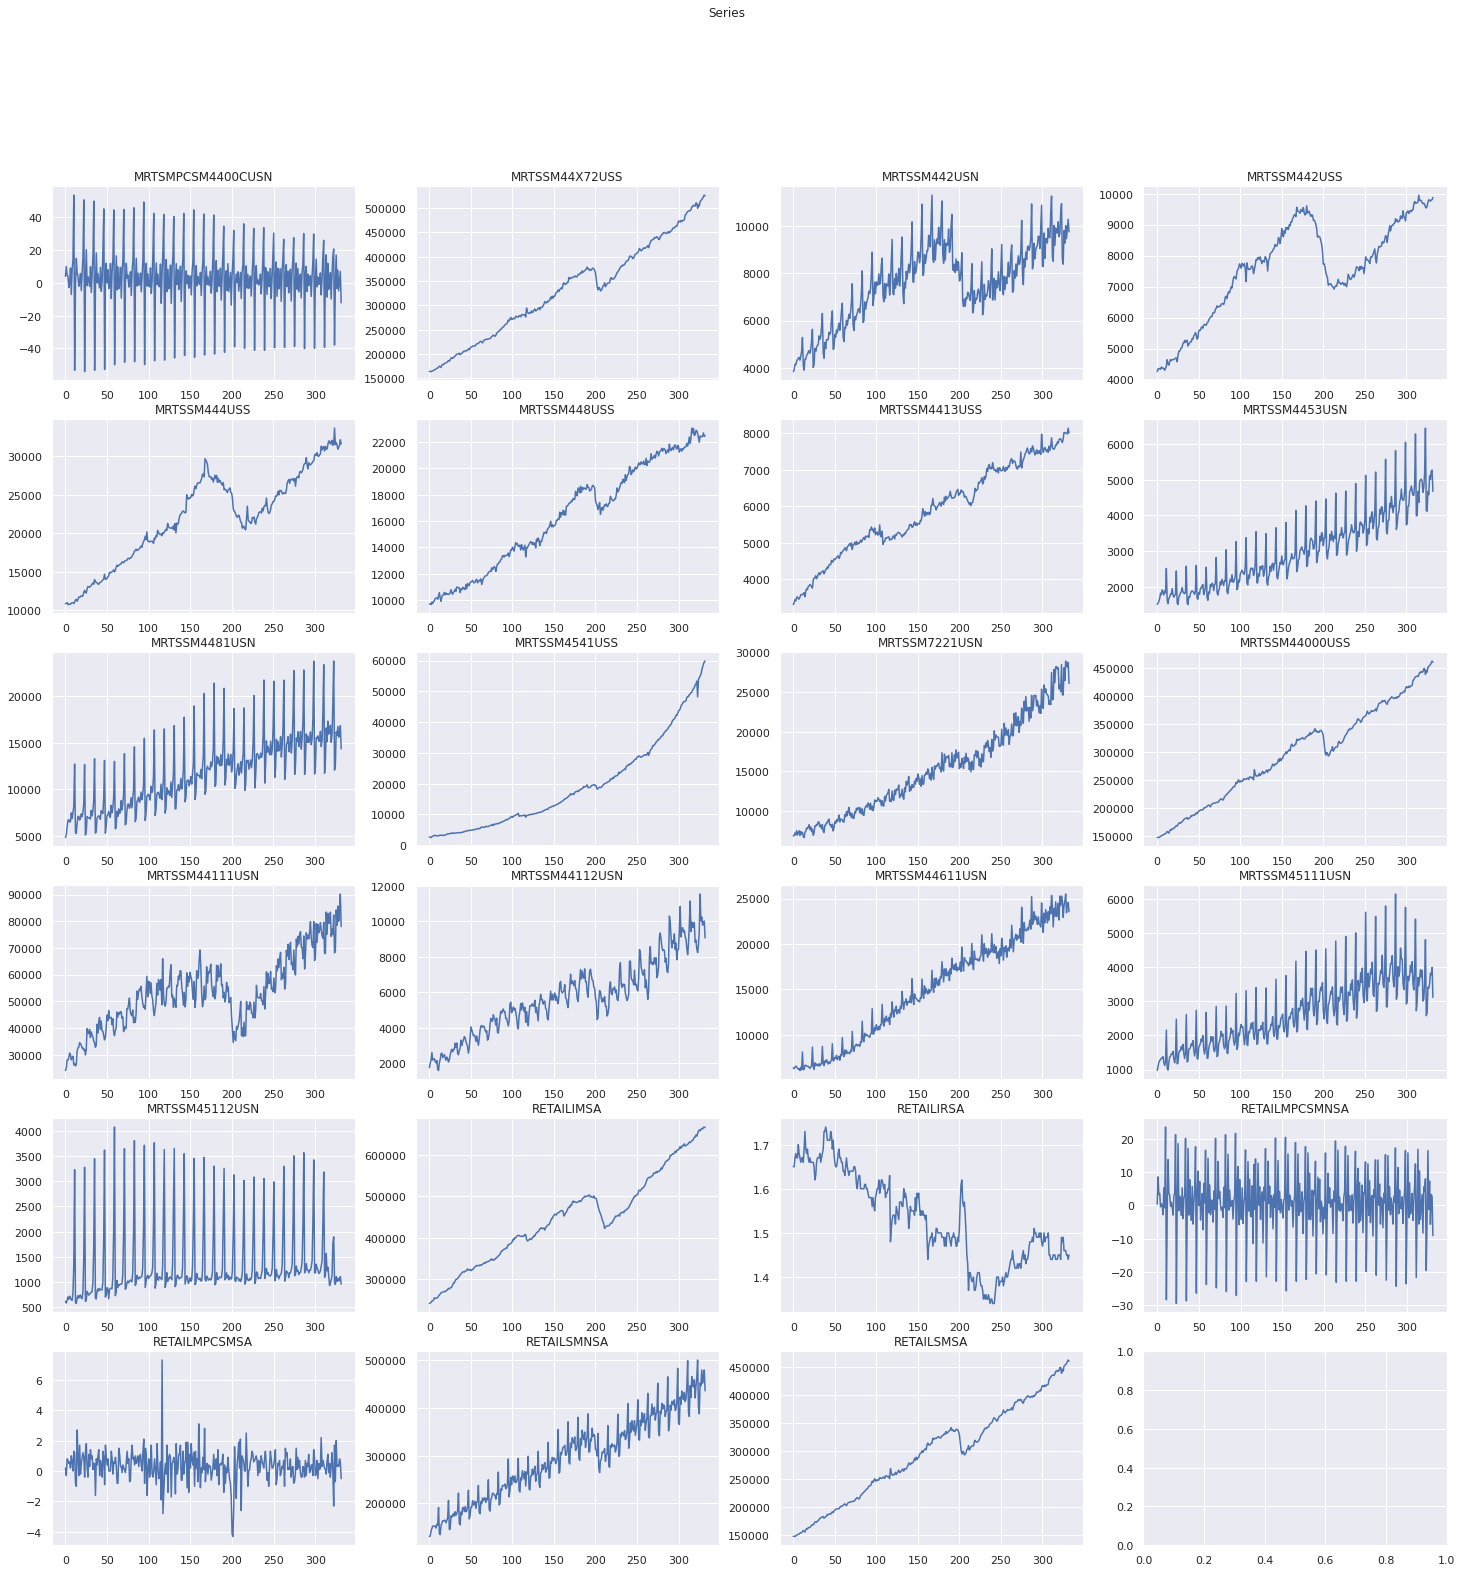

In [30]:
fig, axs = plt.subplots(6,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(mySeries): # pass the others that we can't fill
            continue
        axs[i, j].plot(mySeries[i*4+j].values)
        axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()

## **Data Preprocessing**

In [31]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{332, 333}


In [32]:
ind = 0
for series in mySeries:
    print("["+str(ind)+"] "+series.index[0]+" "+series.index[len(series)-1])
    ind+=1

[0] 1992-02-01 2019-09-01
[1] 1992-01-01 2019-09-01
[2] 1992-01-01 2019-09-01
[3] 1992-01-01 2019-09-01
[4] 1992-01-01 2019-09-01
[5] 1992-01-01 2019-09-01
[6] 1992-01-01 2019-09-01
[7] 1992-01-01 2019-09-01
[8] 1992-01-01 2019-09-01
[9] 1992-01-01 2019-09-01
[10] 1992-01-01 2019-09-01
[11] 1992-01-01 2019-09-01
[12] 1992-01-01 2019-09-01
[13] 1992-01-01 2019-09-01
[14] 1992-01-01 2019-09-01
[15] 1992-01-01 2019-09-01
[16] 1992-01-01 2019-09-01
[17] 1992-01-01 2019-09-01
[18] 1992-01-01 2019-09-01
[19] 1992-02-01 2019-09-01
[20] 1992-02-01 2019-09-01
[21] 1992-01-01 2019-09-01
[22] 1992-01-01 2019-09-01


In [33]:
max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In [34]:
problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

In [35]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [36]:
nan_counter(mySeries)

3


In [37]:
for i in problems_index:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

In [38]:
nan_counter(mySeries)

0


In [39]:
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [4]:
!pip install tslearn

     |████████████████████████████████| 793 kB 15.4 MB/s 


## **Normalization**

In [40]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [41]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])

max: 1.0	min: 0.0
[0.53953488 0.53953488 0.59627907 0.54697674 0.54139535]


## **Clustering Using Self Organized Maps (SOM)**

In [42]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))

som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 50000)

In [43]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

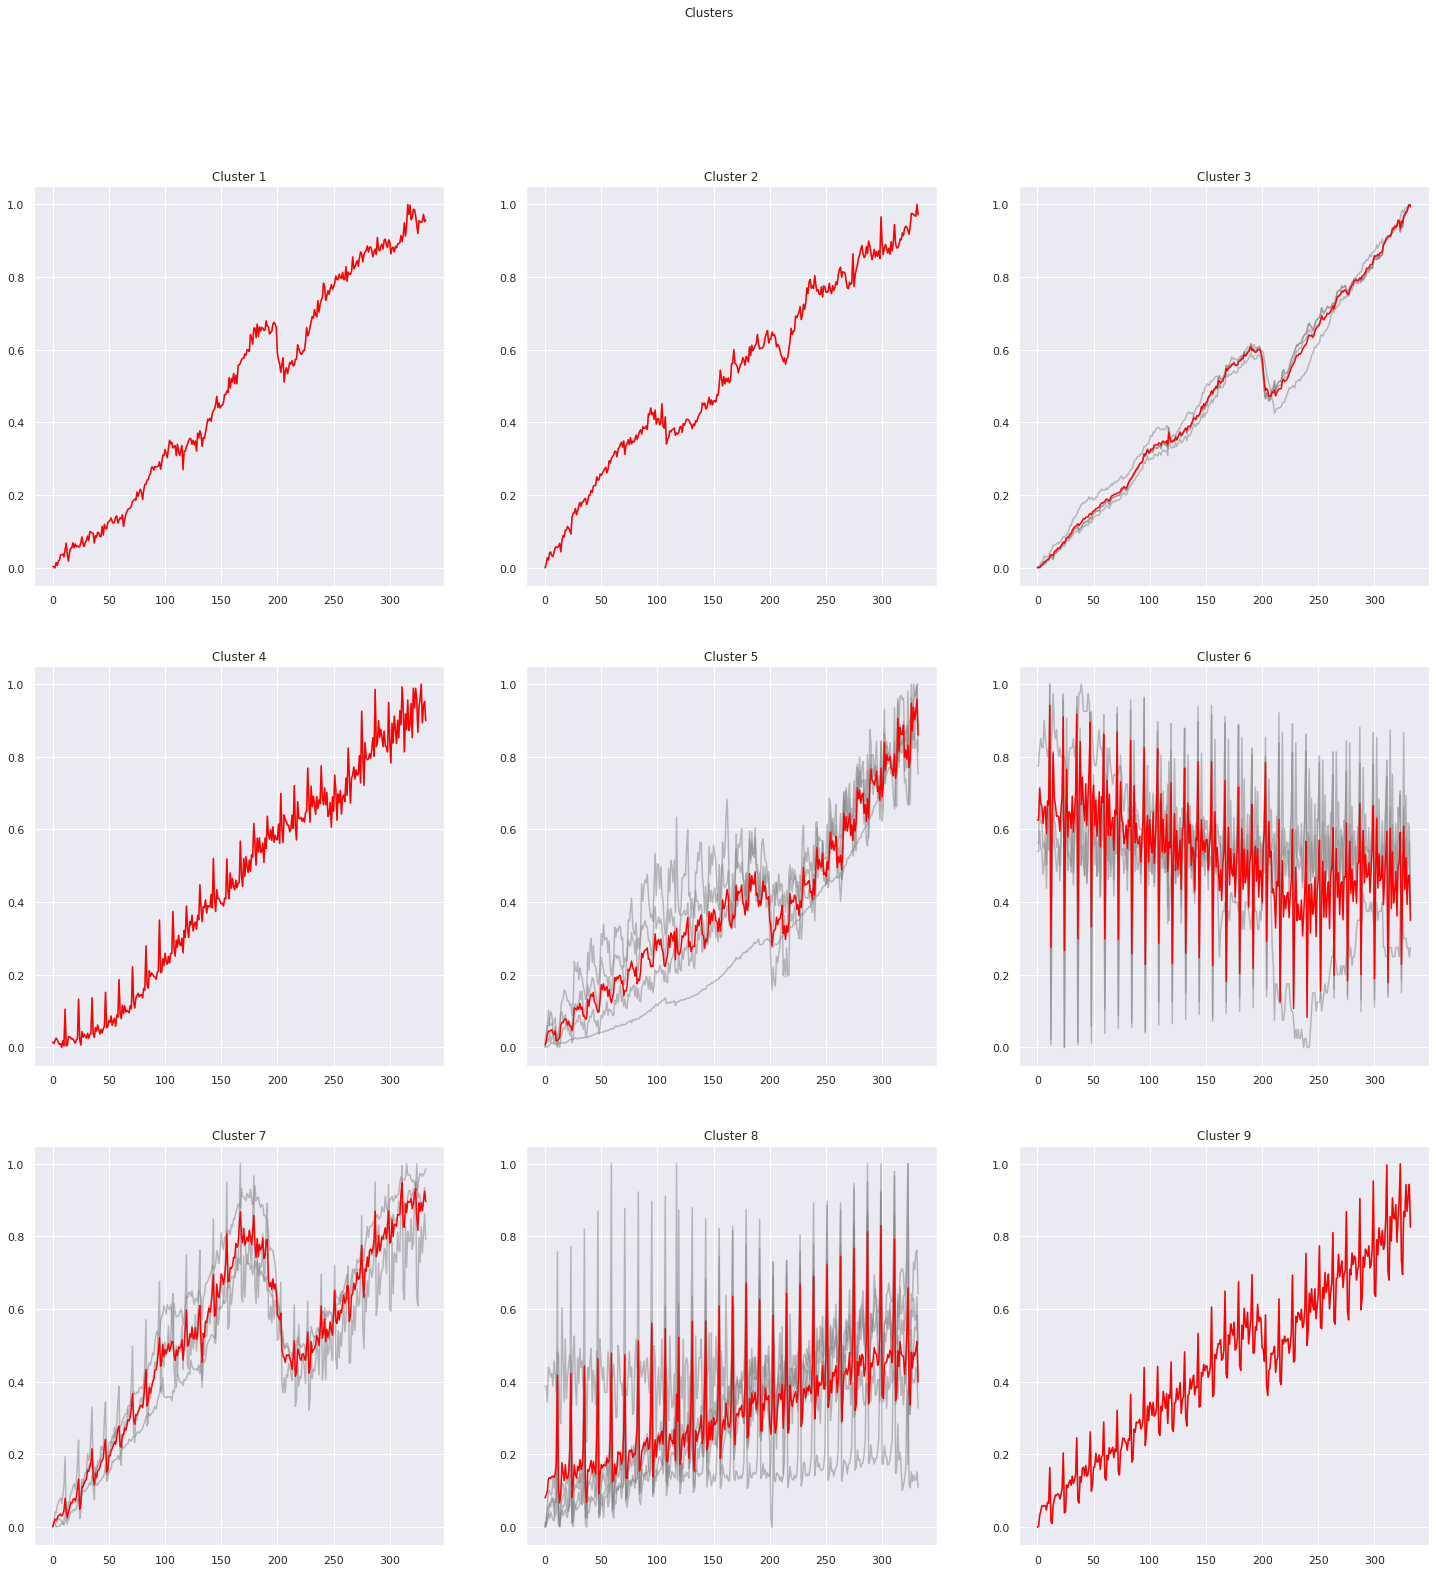

In [44]:
win_map = som.win_map(mySeries)
plot_som_series_averaged_center(som_x, som_y, win_map)

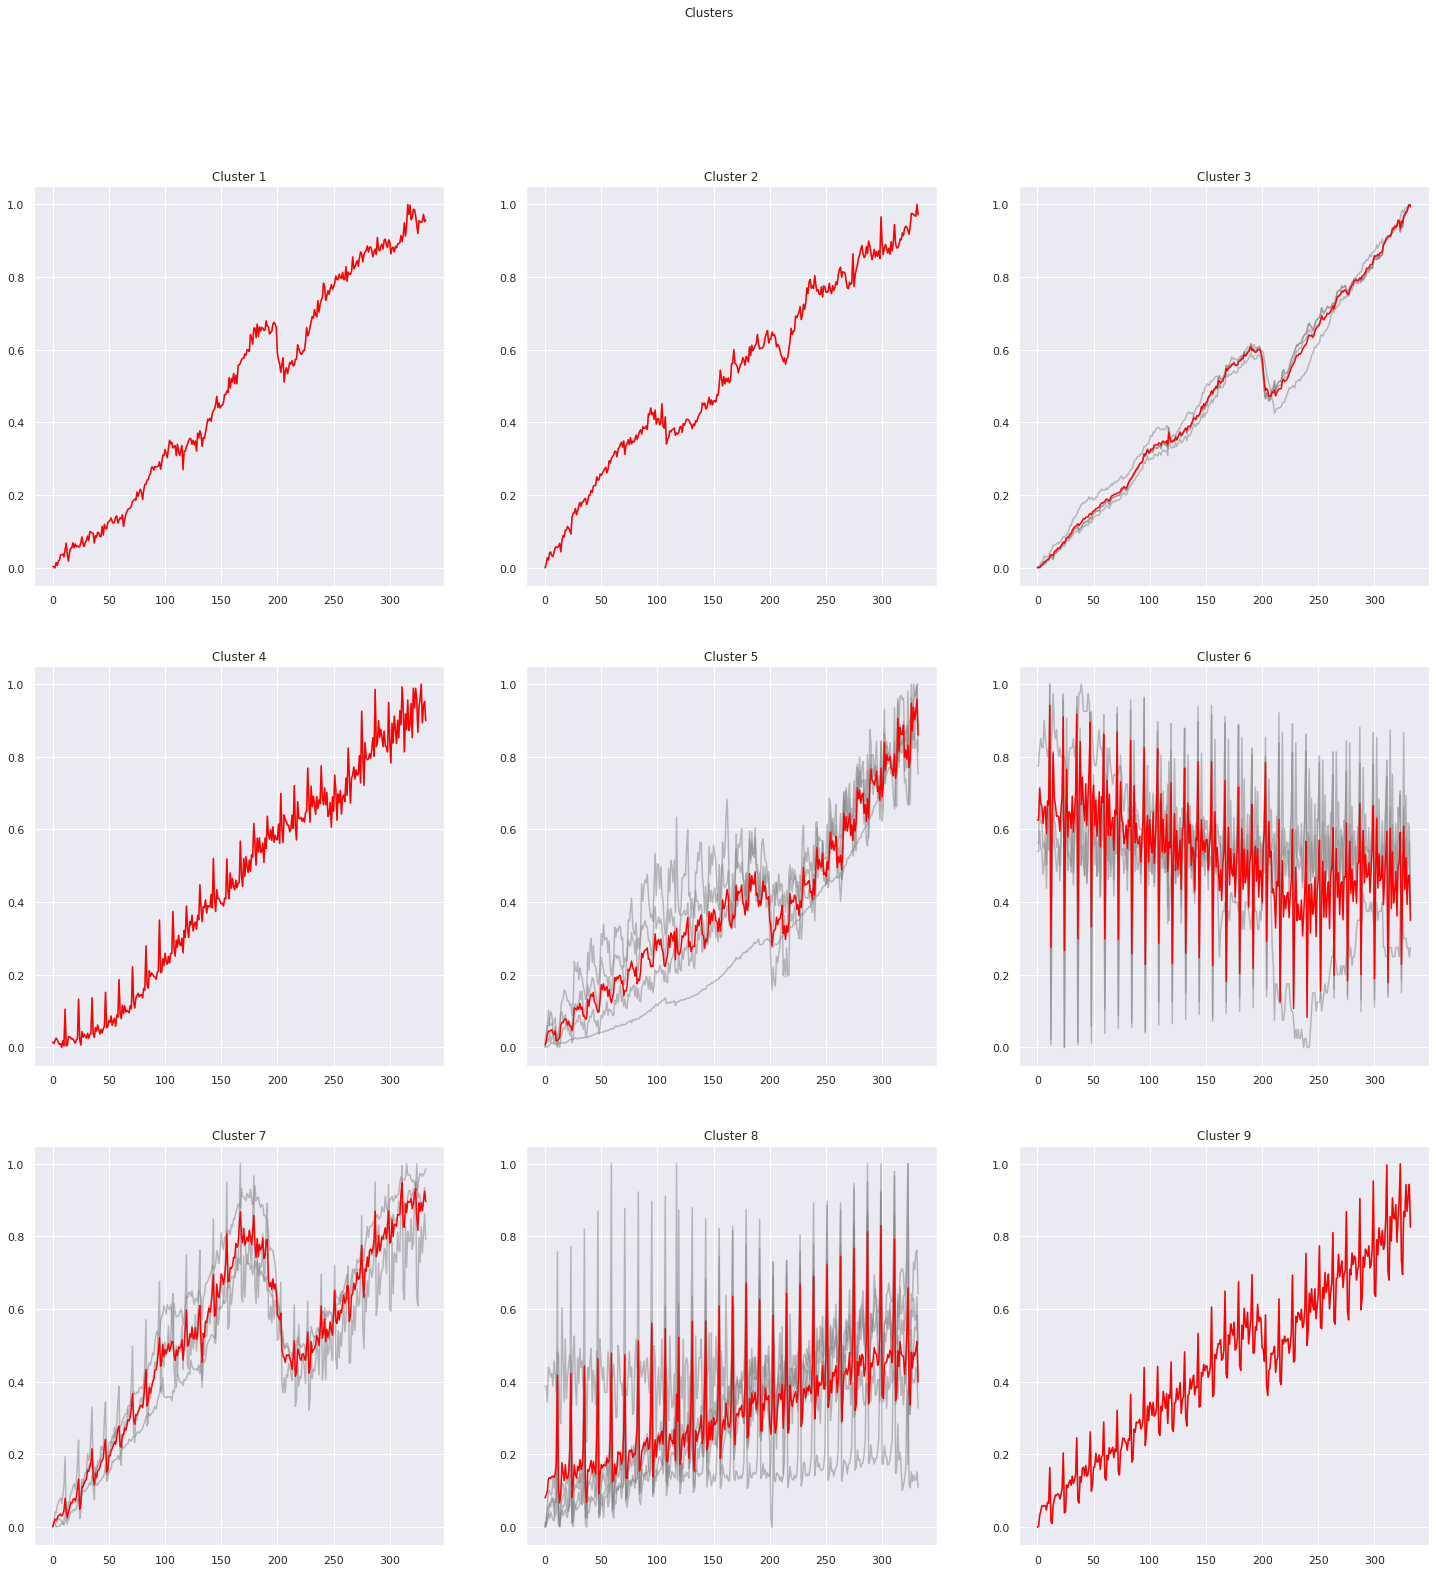

In [45]:
win_map = som.win_map(mySeries)
plot_som_series_averaged_center(som_x, som_y, win_map)

## **Dynamic Time Warping Barycenter Averaging (DBA)**

In [46]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

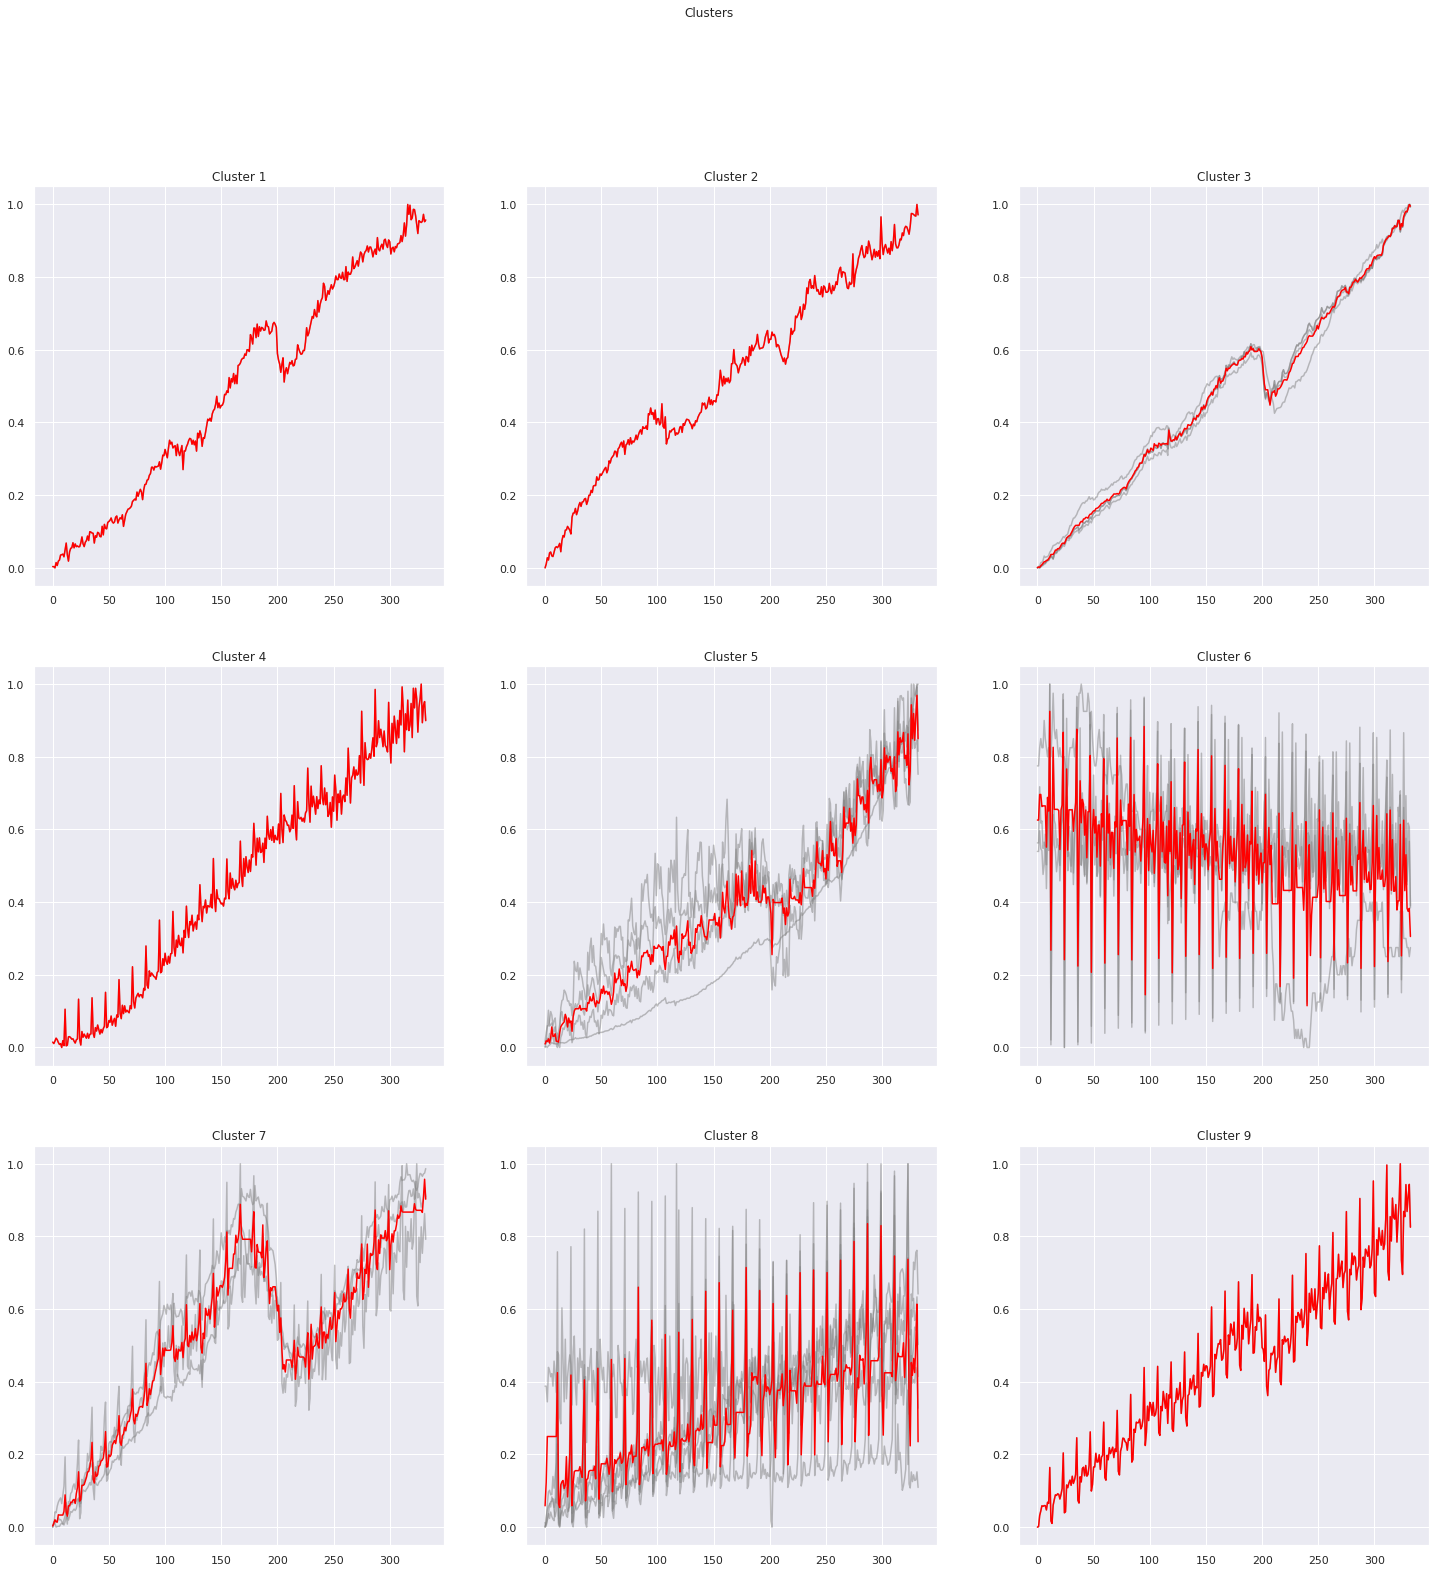

In [47]:
win_map = som.win_map(mySeries)
plot_som_series_dba_center(som_x, som_y, win_map)

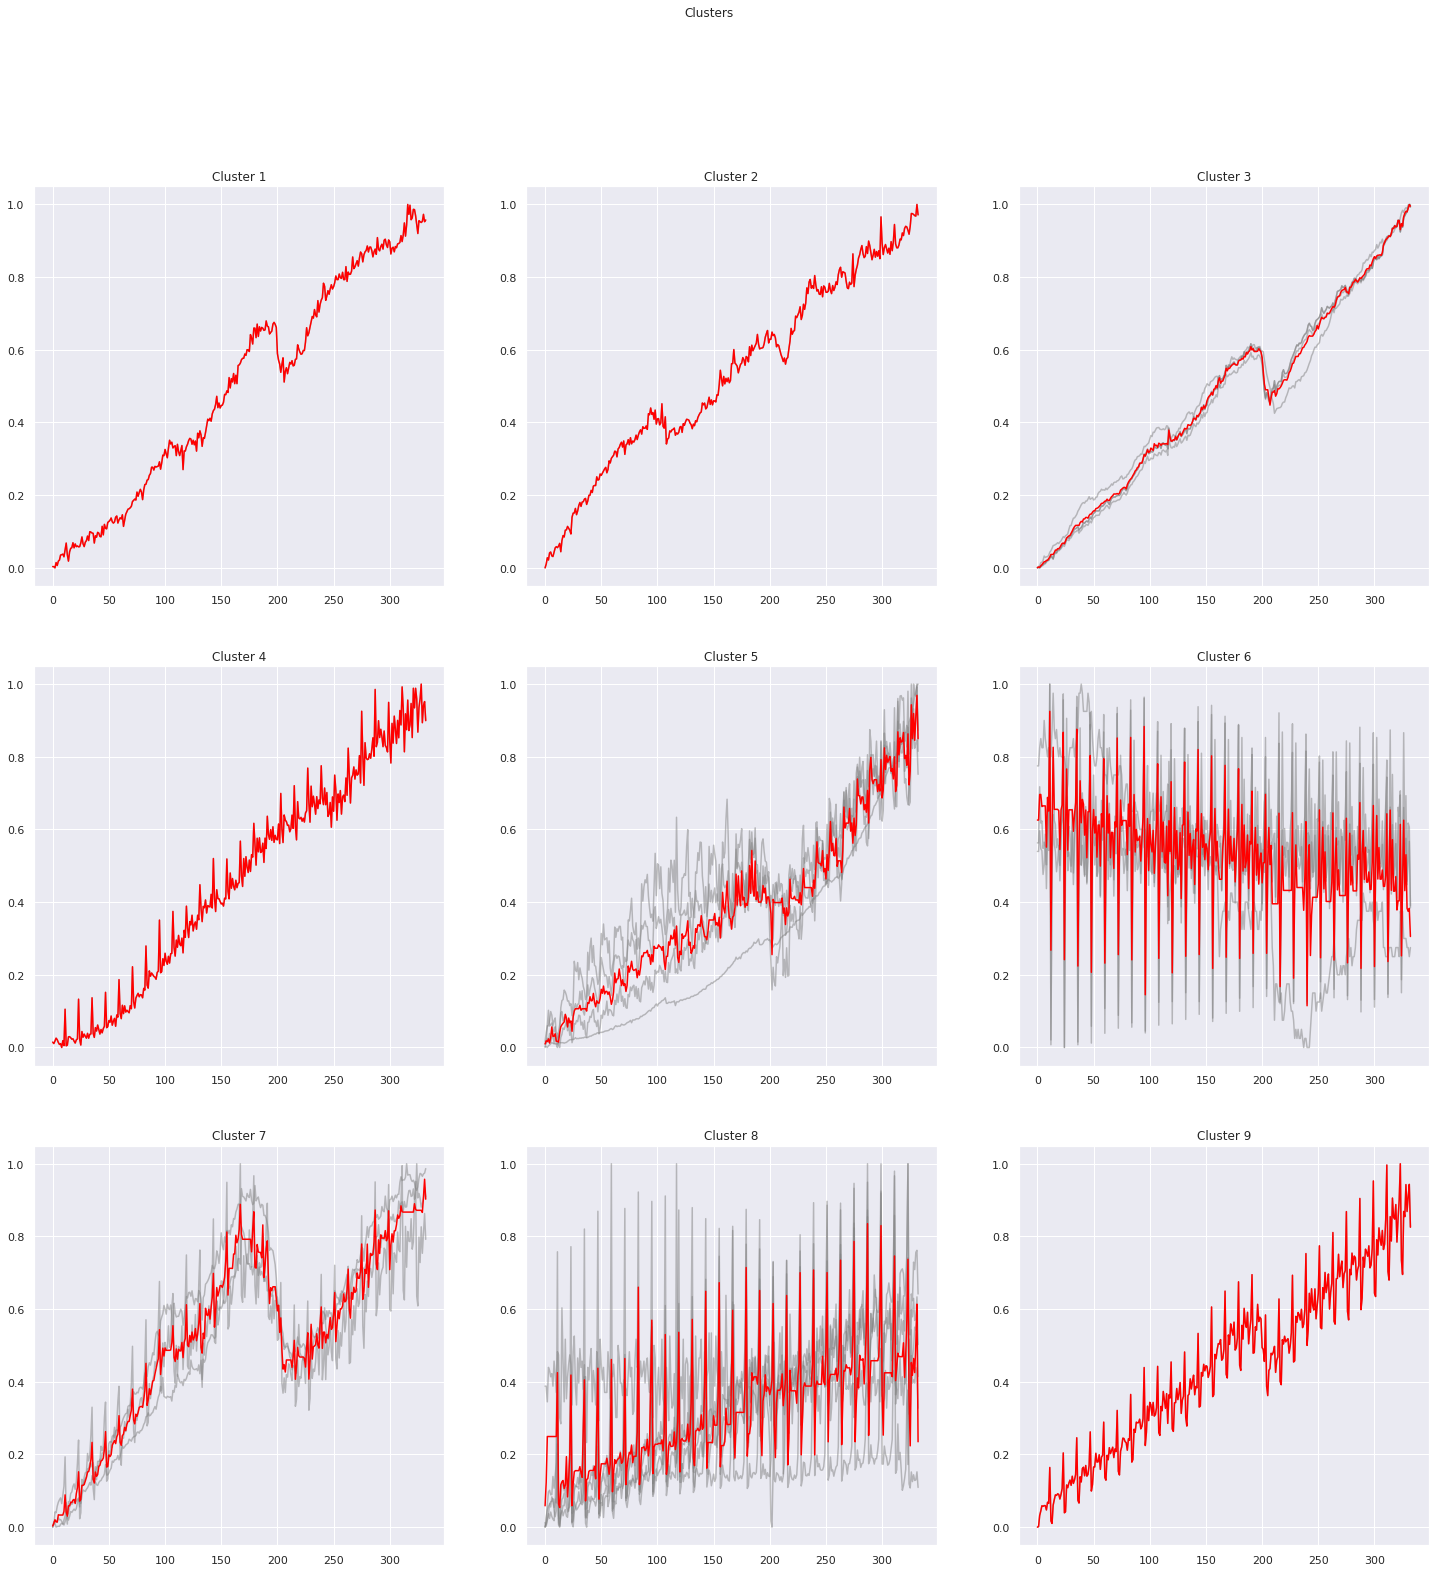

In [48]:
win_map = som.win_map(mySeries)
plot_som_series_dba_center(som_x, som_y, win_map)

## **Clustering**

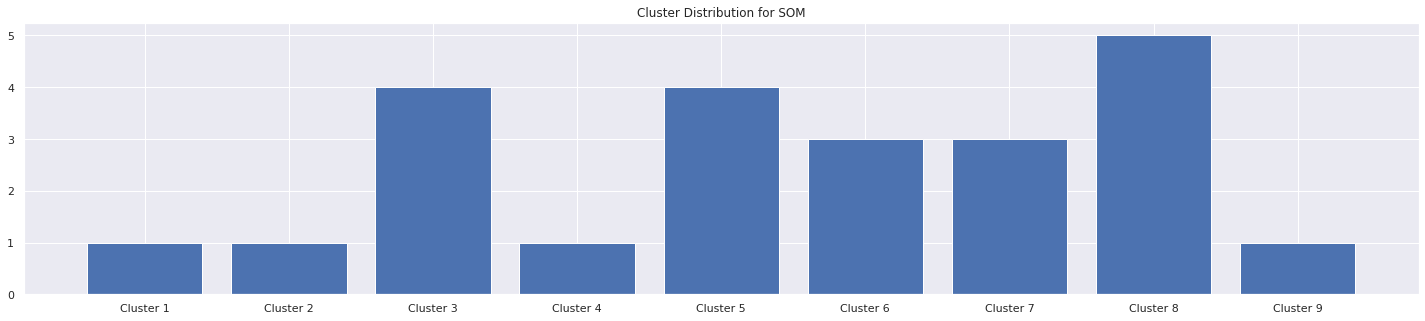

In [49]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

## **Cluster Mapping**

In [50]:
for series in mySeries[:5]:
    print(som.winner(series))

(1, 2)
(0, 2)
(2, 0)
(2, 0)
(2, 0)


In [51]:
cluster_map = []
for idx in range(len(mySeries)):
    winner_node = som.winner(mySeries[idx])
    cluster_map.append((namesofMySeries[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))
pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

Cluster
Series                      
MRTSSM448USS       Cluster 1
MRTSSM4413USS      Cluster 2
MRTSSM44000USS     Cluster 3
RETAILIMSA         Cluster 3
RETAILSMSA         Cluster 3
MRTSSM44X72USS     Cluster 3
MRTSSM44611USN     Cluster 4
MRTSSM44112USN     Cluster 5
MRTSSM4541USS      Cluster 5
MRTSSM7221USN      Cluster 5
MRTSSM44111USN     Cluster 5
RETAILMPCSMNSA     Cluster 6
RETAILIRSA         Cluster 6
MRTSMPCSM4400CUSN  Cluster 6
MRTSSM442USN       Cluster 7
MRTSSM444USS       Cluster 7
MRTSSM442USS       Cluster 7
MRTSSM45111USN     Cluster 8
MRTSSM45112USN     Cluster 8
MRTSSM4481USN      Cluster 8
MRTSSM4453USN      Cluster 8
RETAILMPCSMSA      Cluster 8
RETAILSMNSA        Cluster 9

## **Clustering Using Kmeans**

In [52]:
cluster_count = math.ceil(math.sqrt(len(mySeries))) 
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
labels = km.fit_predict(mySeries)

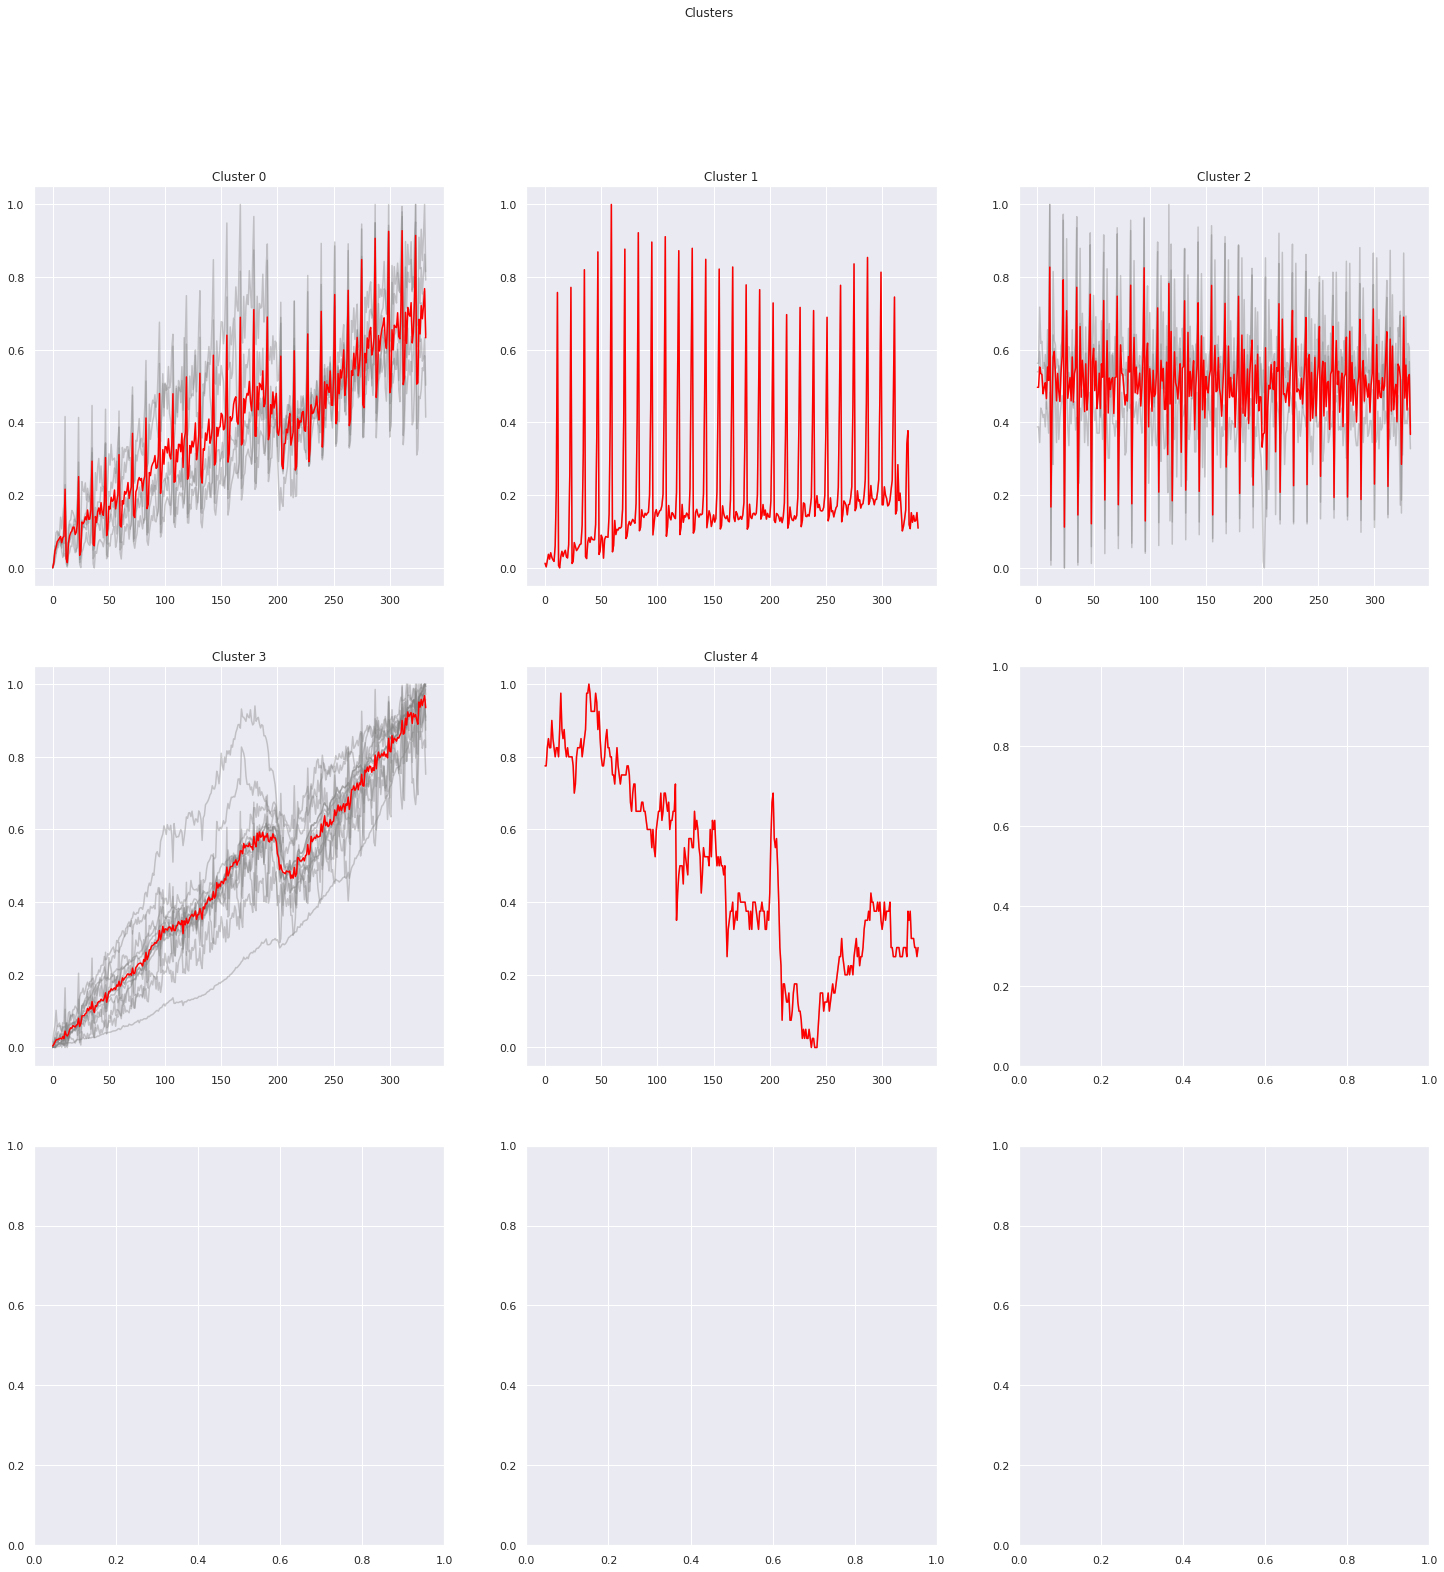

In [53]:
plot_count = math.ceil(math.sqrt(cluster_count))
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0       
plt.show()

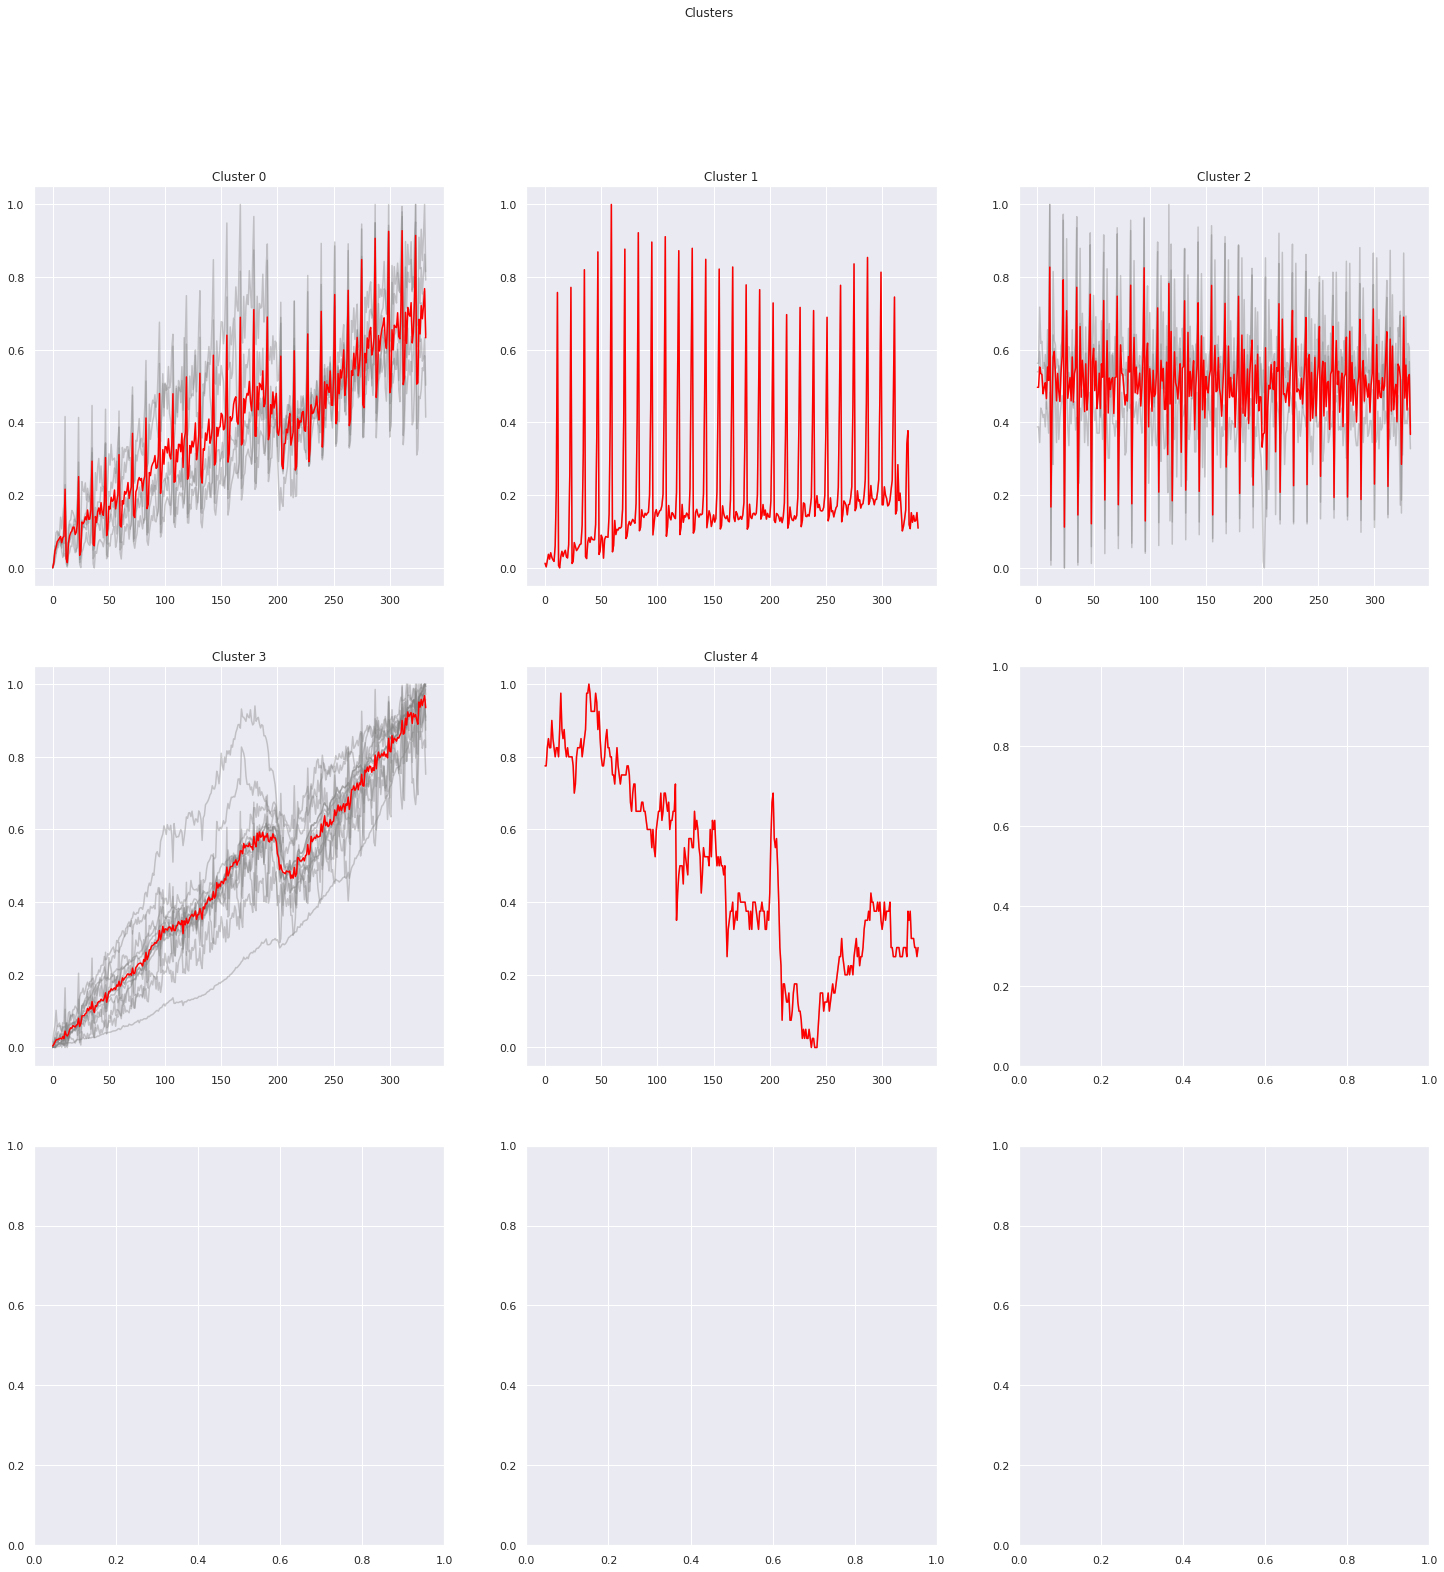

In [54]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0        
plt.show()

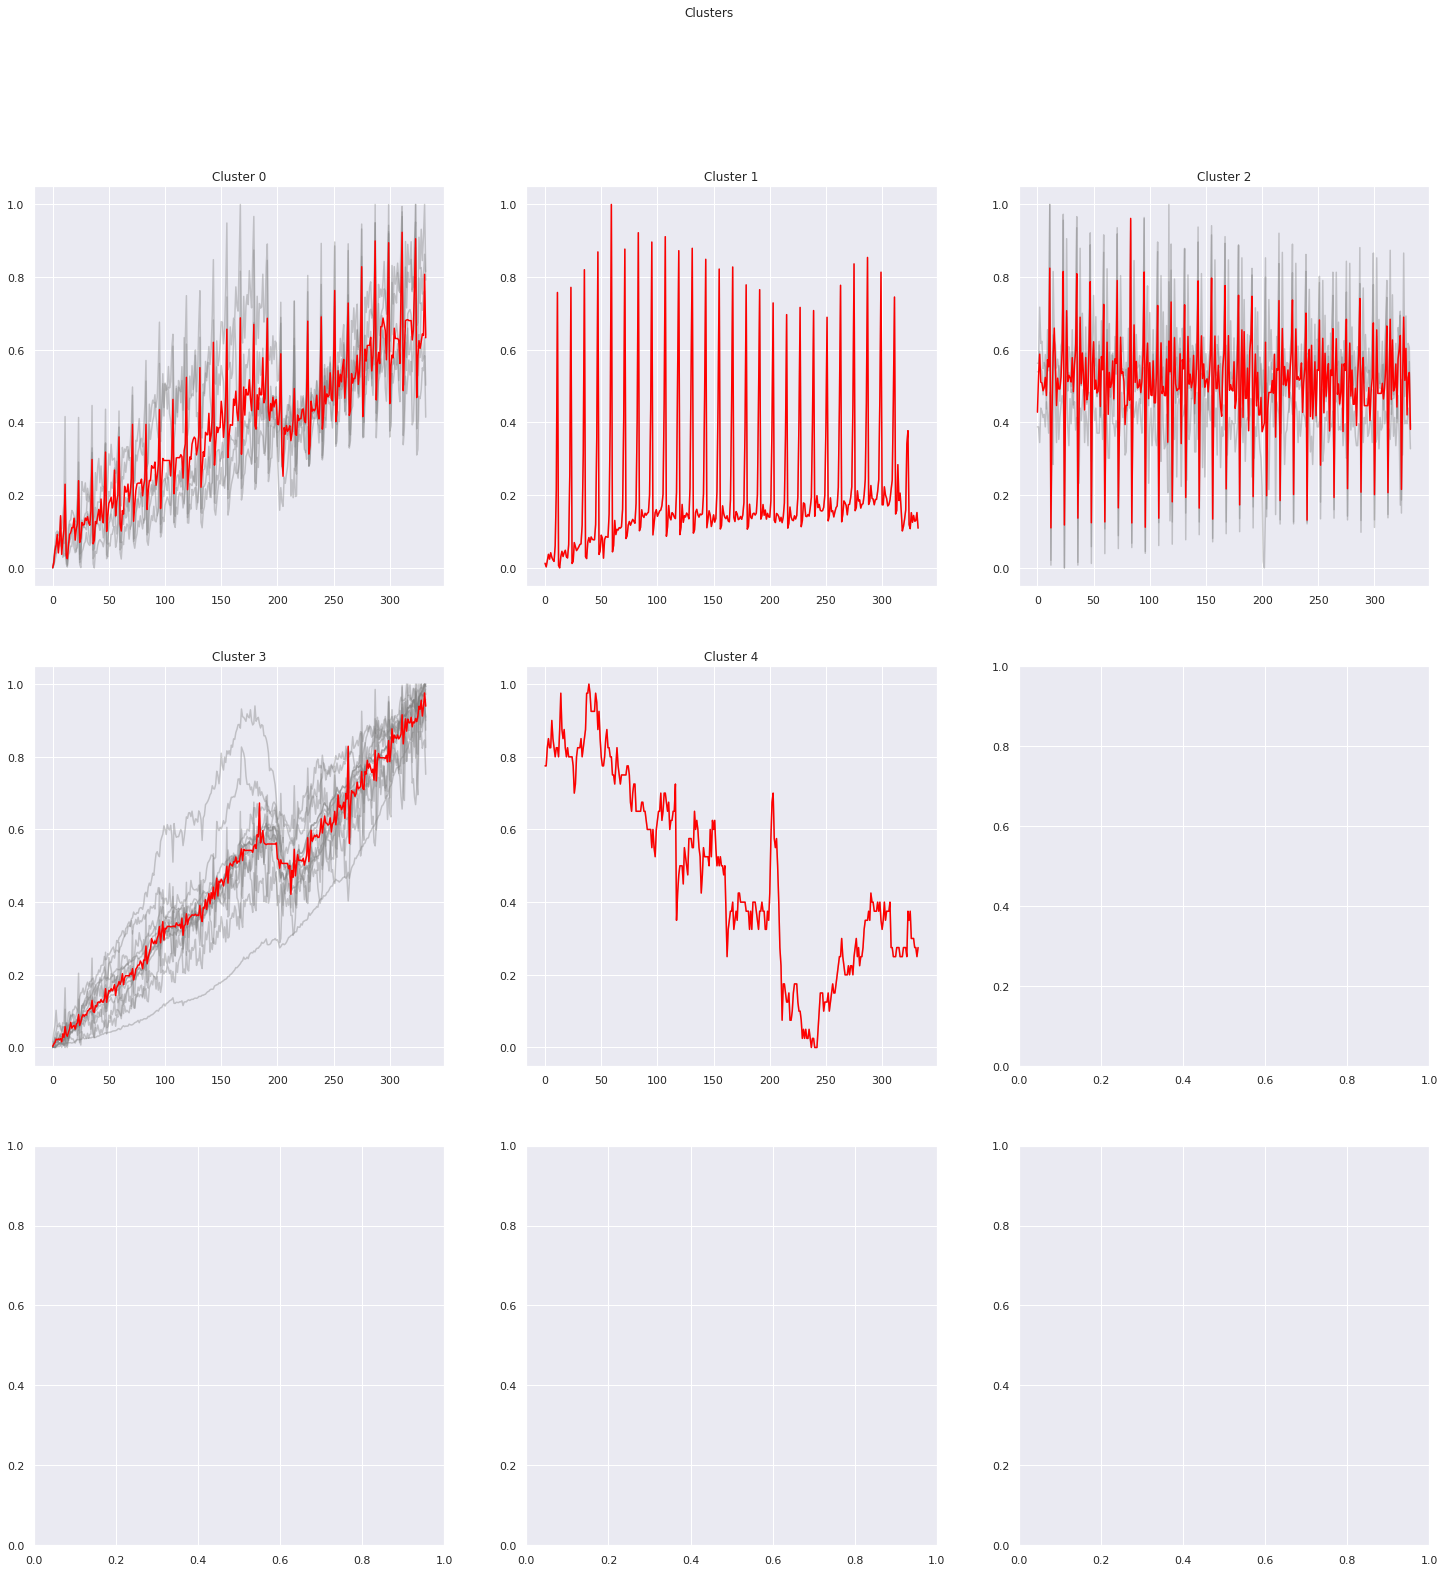

In [55]:
plot_count = math.ceil(math.sqrt(cluster_count))
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0        
plt.show()

## **Clustering**

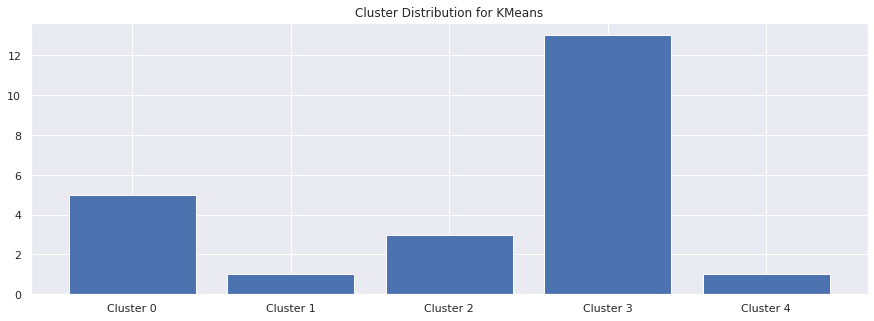

In [56]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [57]:
labels

array([2, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 0, 1, 3, 4, 2, 2, 3,
       3])

## **Cluster Mapping**

In [58]:
original_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,original_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

Cluster
Series                      
MRTSSM442USN       Cluster 0
MRTSSM45111USN     Cluster 0
MRTSSM4453USN      Cluster 0
MRTSSM4481USN      Cluster 0
MRTSSM44111USN     Cluster 0
MRTSSM45112USN     Cluster 1
MRTSMPCSM4400CUSN  Cluster 2
RETAILMPCSMSA      Cluster 2
RETAILMPCSMNSA     Cluster 2
RETAILIMSA         Cluster 3
MRTSSM44611USN     Cluster 3
MRTSSM44112USN     Cluster 3
MRTSSM44000USS     Cluster 3
MRTSSM7221USN      Cluster 3
MRTSSM4541USS      Cluster 3
MRTSSM4413USS      Cluster 3
MRTSSM448USS       Cluster 3
MRTSSM444USS       Cluster 3
MRTSSM442USS       Cluster 3
MRTSSM44X72USS     Cluster 3
RETAILSMNSA        Cluster 3
RETAILSMSA         Cluster 3
RETAILIRSA         Cluster 4

## **Dimentionality Reduction Using PCA**

In [59]:
pca = PCA(n_components=2)
mySeries_transformed = pca.fit_transform(mySeries)

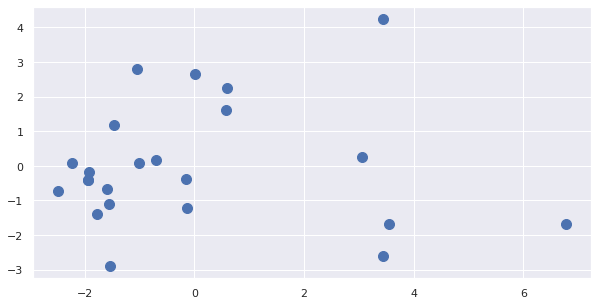

In [60]:
plt.figure(figsize=(10,5))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=100)
plt.show()

In [61]:
print(mySeries_transformed[0:5])

[[ 3.55106153 -1.66874895]
 [-1.92616868 -0.18032212]
 [-0.13861537 -1.22886638]
 [-1.53359961 -2.89464724]
 [-1.54782595 -1.10007376]]


In [62]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

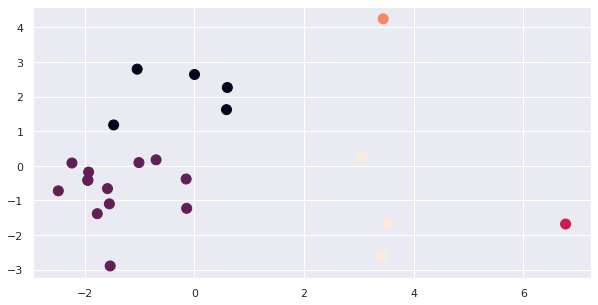

In [65]:
plt.figure(figsize=(10,5))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=100)
plt.show()

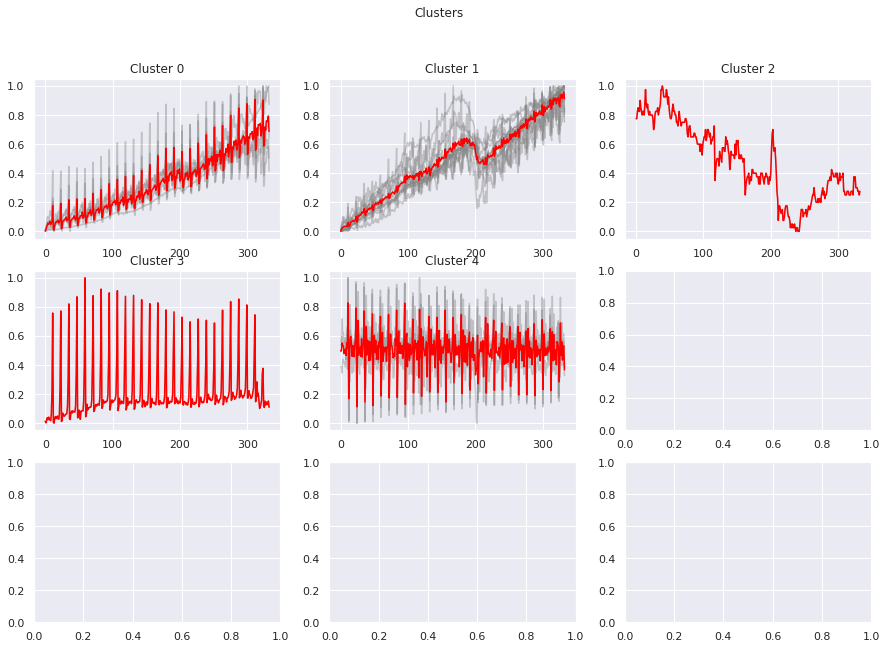

In [66]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(15,10))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

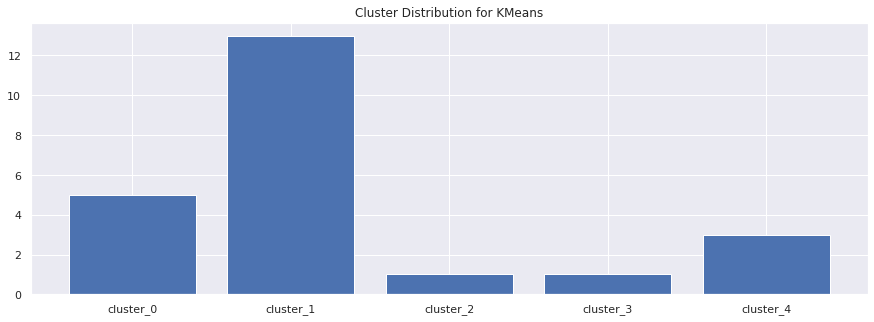

In [67]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [68]:
original_tags = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,original_tags),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

Cluster
Series                      
MRTSSM45111USN     Cluster 0
MRTSSM4453USN      Cluster 0
MRTSSM4481USN      Cluster 0
MRTSSM4541USS      Cluster 0
MRTSSM7221USN      Cluster 0
MRTSSM44000USS     Cluster 1
RETAILIMSA         Cluster 1
MRTSSM44611USN     Cluster 1
MRTSSM44112USN     Cluster 1
MRTSSM44111USN     Cluster 1
RETAILSMNSA        Cluster 1
RETAILSMSA         Cluster 1
MRTSSM448USS       Cluster 1
MRTSSM444USS       Cluster 1
MRTSSM442USS       Cluster 1
MRTSSM442USN       Cluster 1
MRTSSM44X72USS     Cluster 1
MRTSSM4413USS      Cluster 1
RETAILIRSA         Cluster 2
MRTSSM45112USN     Cluster 3
RETAILMPCSMNSA     Cluster 4
RETAILMPCSMSA      Cluster 4
MRTSMPCSM4400CUSN  Cluster 4